In [13]:
import numpy as np
import pandas as pd
import networkx as nx
import random as rd
import matplotlib as plt
from pickle import*
from gurobi import*
def count_average_degree(mat):
    link_count = 0
    n = len(m)
    for i in range(n):
        for j in range(n):
            if (mat[i][j] == 1):
                link_count = link_count+1
                
    return link_count




def ratio_model(mat):
    #Weights level 2 generation
    We2 = mat.copy()
    incoming_edges = []
    n = len(mat)
    for i in range(n):
        node_degree = np.sum(mat[i])
        incoming_edges.append(node_degree)
        
    for i in range(n):
        for j in range(n):
            if (mat[i][j] == 1):
                We2[i][j] = 1/incoming_edges[j]
                
                
    #Weights level 1 generation
    
    We1 = We2.copy()
    for i in range(n):
        for j in range(n):
            if (We2[i][j] > 0):
                We2[i][j] = We2[i][j] *0.5
    return We1,We2





def random_threshold(mat):
    #Thresholds level 1 generation
    #Level 1 thresholds are random for now
    n = len(mat)
    Th1 = []
    for i in range(n):
        Th1.append(0)
        
    for i in range(n):
        Th1[i] = rd.uniform(0.1, 0.75)
            
    #Thresholds level 2 generation
    #Thresholds level 2 are Level1 + 0.25 for now
    Th2 = Th1.copy()
    for i in range(n):  
        Th2[i] = Th2[i] + 0.25
    return Th1,Th2

def generate_costs()


In [14]:
# Network generation and saving via pickle
G = nx.barabasi_albert_graph(10,2,123)
#G = nx.read_gpickle("graph1")
#nx.write_gpickle(G,"graph1")

#Weight generation flags
is_ratio_model = True 
is_hybrid_model = False

#Threshold generation flags
is_random_threshold = True

In [15]:
adj_matrix = nx.to_numpy_array(G)

#Weight generation
if (is_ratio_model == True):
    W1,W2 = ratio_model(adj_matrix)

if (is_hybrid_model == True):
    W1,W2 = hybrid_model(adj_matrix)
    
    
W1 = W1.tolist()
W2 = W2.tolist()
W = []
W.append(W1)
W.append(W2)

#Threshold generation

if (is_random_threshold == True):
    T1,T2 = random_threshold(adj_matrix)


T = []
T.append(T1)
T.append(T2)

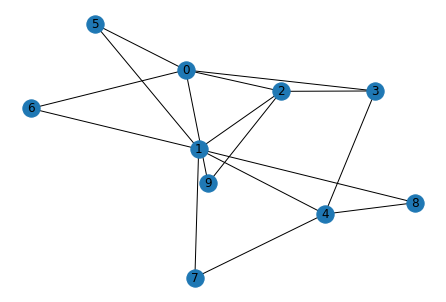

In [16]:
nx.draw(G, with_labels = True) 

In [17]:
#Initialization of remaining parameters
Time = [0,1,2,3,4]
n_of_nodes = len(adj_matrix)
Nodes = []
for i in range(n_of_nodes):
    Nodes.append(i)

In [20]:
#gurobi model initialization
model = Model()



Y = model.addVars(Nodes,Time,vtype = GRB.BINARY,name = "Y")
X = model.addVars(Nodes,Time,vtype = GRB.BINARY,name = "X")
U = model.addVars(Nodes,vtype = GRB.BINARY,name = "U")

model.modelSense = GRB.MAXIMIZE

#cons1
expr1 = LinExpr(quicksum(U[i] for i in Nodes))
model.addConstr(expr1 <= 550node.py , name = "cons1")  

#cons2
model.addConstrs(Y[i,0] == U[i]   for i in Nodes)

#cons3
model.addConstrs(X[i,0] == 0 for i in Nodes)

#cons4
model.addConstrs(Y[i,t-1] <= Y[i,t] for i in Nodes for t in range(1,len(Time)))

#cons5
model.addConstrs(quicksum(W1[i][j]*X[i,t-1] for i in Nodes) + quicksum(W2[i][j]*Y[i,t-1] for i in Nodes)+U[j]
                >= T[0][j]*X[j,t]for j in Nodes for t in range(1,len(Time)))


model.addConstrs(quicksum(W1[i][j]*X[i,t-1] for i in Nodes) + quicksum(W2[i][j]*Y[i,t-1] for i in Nodes) +U[j]
                >= T[1][j]*Y[j,t]for j in Nodes for t in range(1,len(Time)))

#cons6

model.addConstrs(X[i,t] + Y[i,t] <= 1 for i in Nodes for t in Time)

#Objective Function

model.setObjective(Y.sum("*",4),GRB.MAXIMIZE)


model.optimize()



print('buying at t=0')
for i in Nodes:
    if U[i].x == 1:
        print(i)


print('buying at t=4')
for i in Nodes:
    if Y[i,4].x == 1:
        print(i)


Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 191 rows, 110 columns and 892 nonzeros
Model fingerprint: 0xf659db82
Variable types: 0 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 68 rows and 39 columns
Presolve time: 0.01s
Presolved: 123 rows, 71 columns, 579 nonzeros
Variable types: 0 continuous, 71 integer (71 binary)

Root relaxation: objective 1.000000e+01, 46 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      10.0000000   10.00000  0.00%     -    0s
     0     0   10.00000    0   27   10.00000   10.00000  0.00%     -    0s

Explored 0 nodes (46 simplex iterations) in 0.06 seconds
Th